In [1]:
import tensorflow as tf

# Importing matplotlib to plot images.
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import pandas as pd
# Importing SK-learn to calculate precision and recall
import sklearn
import sklearn.metrics

# Used for graph export
from tensorflow.python.framework import graph_util
from tensorflow.python.framework import graph_io
from keras.models import load_model
from keras import backend as K

tf.__version__

Using TensorFlow backend.


'1.5.0'

In [2]:

#for i in {1,2,3,4,6,8,9}:
#    df1 = pd.read_pickle("./Pickles/processed_pck{}.pkl".format(i))
#    if(i == 1):
#        df = df1.copy()
#    else:
#        temp = [df,df1]
#        df = pd.concat(temp) 

#df.to_pickle('train_set.pkl')

In [3]:
train_set = pd.read_pickle('train_set.pkl')
train_set = train_set.sample(frac=1)
print(train_set.shape)

(261257, 6)


In [4]:
train_set.head()

,aray2,indx,x_actual,x_curr,y_actual,y_curr
26725,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6.0,675.0,660.0,1099.0,1107.0
50168,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5.0,859.0,851.0,1437.0,1355.0
17031,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",8.0,69.0,41.0,1242.0,1214.0
4982,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 34, 161, 156, 2...",9.0,863.0,823.0,75.0,35.0
17301,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",32.0,70.0,42.0,1492.0,1410.0


In [5]:
validation_set = pd.read_pickle('validation_set.pkl')
validation_set = validation_set.sample(frac=1)
print(validation_set.shape)

(79469, 6)


In [6]:
y_train = train_set[['x_curr', 'y_curr']].values
y_test = validation_set[['x_curr', 'y_curr']].values


In [7]:
img_rows, img_cols = 27, 15
x_train = []
[x_train.append(np.reshape(a,(img_rows,img_cols, 1))) for a in train_set.aray2]
x_train = np.asarray(x_train)
x_train = x_train.astype(np.float64)
x_train /= 255

x_test = []
[x_test.append(np.reshape(a,(img_rows,img_cols, 1))) for a in validation_set.aray2]
x_test = np.asarray(x_test)
x_test = x_test.astype(np.float64)
x_test /= 255

In [8]:
del train_set
del validation_set

In [9]:
print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)

(261257, 27, 15, 1)
(261257, 2)
(79469, 27, 15, 1)
(79469, 2)


[631. 910.]


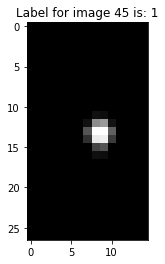

In [10]:
i = 45
plt.imshow(x_train[i].reshape(27, 15),cmap='gray') #np.sqrt(784) = 28
plt.title("Label for image %i is: %s" % (i, np.argmax(y_train[i])))
print(y_train[i])

In [11]:
# If GPU is not available: 
# GPU_USE = '/cpu:0'
# config = tf.ConfigProto(device_count = {"GPU": 0})


# If GPU is available: 
config = tf.ConfigProto()
config.log_device_placement = True
config.allow_soft_placement = True
config.gpu_options.allocator_type = 'BFC'

# Limit the maximum memory used
config.gpu_options.per_process_gpu_memory_fraction = 0.4

# set session config
tf.keras.backend.set_session(tf.Session(config=config))

In [12]:

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [13]:
########## HYPER PARAMETERS
batch_size = 10
epochs = 1000
optimizer = tf.keras.optimizers.Adam(decay=0.001)
########## HYPER PARAMETERS

In [14]:
########## MODEL ARCHITECTURE
model = tf.keras.Sequential()

### OLD ARCHITECTURE START
#model.add(tf.keras.layers.Dense(5, activation='relu', input_shape=(784,)))
### OLD ARCHITECTURE END

### NEW CNN ARCHITECTURE
model.add(tf.keras.layers.Conv2D(5, kernel_size=(3, 3),
                                 activation='relu',
                                 #padding='same',
                                 input_shape=input_shape))

model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2),
                                       padding='same'))

model.add(tf.keras.layers.Conv2D(5, kernel_size=(3, 3),
                                 activation='relu',
                                 padding='same'))

model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2),
                                       padding='same'))

#model.add(tf.keras.layers.Conv2D(5, kernel_size=(3, 3),
#                                 activation='relu',
#                                 padding='same'))

#model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2),
#                                       padding='same'))
model.add(tf.keras.layers.Flatten())
### NEW CNN ARCHITECTURE
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.25, noise_shape=None, seed=None))

model.add(tf.keras.layers.Dense(2, activation=None))
########## MODEL ARCHITECTURE

# Print summary
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 21, 9, 5)          250       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 5, 5)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 5, 5)          630       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 3, 5)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 90)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               11648     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
__________

In [ ]:
# compile model for training
model.compile(loss='mean_squared_error',
              optimizer=optimizer,
              metrics=['mae','acc'])

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    verbose=1,shuffle=True)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Train on 261257 samples, validate on 79469 samples
Epoch 1/1000


In [ ]:
batch_size

In [ ]:
########## HYPER PARAMETERS
batch_size = 128
epochs = 20
optimizer = tf.keras.optimizers.Adam(decay=0.001)
########## HYPER PARAMETERS

########## MODEL ARCHITECTURE
model = tf.keras.Sequential()

### OLD ARCHITECTURE START
#model.add(tf.keras.layers.Dense(5, activation='relu', input_shape=(784,)))
### OLD ARCHITECTURE END

### NEW CNN ARCHITECTURE
model.add(tf.keras.layers.Conv2D(5, kernel_size=(7, 7), activation='relu', padding='same',input_shape=(27,15,1)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(1,1), padding='same', data_format=None))
model.add(tf.keras.layers.Conv2D(5, kernel_size=(5, 5), activation='relu', padding='same',input_shape=(27,15,1)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(1,1), padding='same', data_format=None))
model.add(tf.keras.layers.Conv2D(5, kernel_size=(3, 3), activation='relu', padding='same',input_shape=(27,15,1)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(1,1), padding='same', data_format=None))
model.add(tf.keras.layers.Flatten())
### NEW CNN ARCHITECTURE
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.25, noise_shape=None, seed=None))

model.add(tf.keras.layers.Dense(2, activation=None))
########## MODEL ARCHITECTURE

# Print summary
model.summary()

# compile model for training
model.compile(loss='mean_squared_error',
              optimizer=optimizer,
              metrics=['mae','acc'])

history = model.fit(x_train, y,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,shuffle=True)

In [ ]:
# use model for inference to get test accuracy
val = (x_test[600]).reshape(-1, 27, 15, 1)
y_test_pred = model.predict(val)
#y_test_pred = np.argmax(y_test_pred, axis=1)

print(y_test_pred)

#print ('\n Summary of the precision, recall, F1 score for each class:')
#print (sklearn.metrics.classification_report(y_test, y_test_pred))

#print ('\n Confusion matrix: ')
#print (sklearn.metrics.confusion_matrix(y_test, y_test_pred))

In [ ]:
print(y_test[600])
print(mob_test[600])

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['val_acc'], label="Test Accuracy")
plt.plot(history.history['acc'], label="Training Accuracy")
plt.legend()

In [ ]:
# save model
model.save("myModel.h5")